In [ ]:
#| default_exp layers

# Functional layers

> JaX/Flax implementation of functional layers.

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
#| eval: false
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
#| export
import jax
from typing import Any, Callable, Sequence, Union
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze
from flax import linen as nn
import optax
from einops import rearrange, repeat

from fxlayers.initializers import *

## Base layer

> First we'll define a base class that will be used by every other functional layer.

In [ ]:
class BaseFunctional(nn.Module):
    """Base functional layer."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    xmean: float = 0.5
    ymean: float = 0.5

    @nn.compact
    def __call__(self,
                 inputs,
                 ):
        sigma = self.param("sigma",
                           nn.initializers.uniform(scale=1),
                           (self.features*inputs.shape[-1],))

        # x, y = jnp.meshgrid(jnp.linspace(0,1,num=self.kernel_size), jnp.linspace(0,1,num=self.kernel_size))
        # kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,None), out_axes=-1)(x, y, self.xmean, self.ymean, sigma, 1)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        kernel = self.generate_kernel()

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        return outputs

    @staticmethod
    def generate_function(x, y, xmean, ymean, sigma, A=1):
        return A*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))

    def return_kernel(self, params):
        x, y = jnp.meshgrid(jnp.linspace(0,1,num=self.kernel_size), jnp.linspace(0,1,num=self.kernel_size))
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,None), out_axes=-1)(x, y, self.xmean, self.ymean, params["params"]["sigma"], 1)
        kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        return kernel

## Gaussian layer

In [ ]:
#| export
class GaussianLayer(nn.Module):
    """Parametric gaussian layer."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    normalize_prob: bool = True
    normalize_energy: bool = False

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        sigma = self.param("sigma",
                           nn.initializers.uniform(scale=self.xmean),
                           (self.features*inputs.shape[-1],))
        A = self.param("A",
                       nn.initializers.ones,
                       (self.features*inputs.shape[-1],))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (self.features,))
        else: bias = 0.

        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, sigma, A, self.normalize_prob, self.normalize_energy)
            # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv_general_dilated(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding,
               feature_group_count=self.feature_group_count)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True, normalize_energy=False):
        # A_norm = 1/(2*jnp.pi*sigma) if normalize_prob else 1.
        A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma**2), 1.)
        gaussian = A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(gaussian**2)), 1.)
        return A*gaussian/E_norm

    def return_kernel(self, params, c_in):
        x, y = self.generate_dominion()
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, params["params"]["sigma"], params["params"]["A"], self.normalize_prob, self.normalize_energy)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=c_in, c_out=self.features)
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size), jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size))

In [ ]:
#| exporti
class GaussianLayerLogSigma(nn.Module):
    """Parametric gaussian layer that optimizes log(sigma) instead of sigma."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    normalize_prob: bool = True
    normalize_energy: bool = False

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        logsigma = self.param("logsigma",
                           bounded_uniform(minval=-4., maxval=-0.5),
                           (self.features*inputs.shape[-1],))
        A = self.param("A",
                       nn.initializers.ones,
                       (self.features*inputs.shape[-1],))
        sigma = jnp.exp(logsigma)
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (self.features,))
        else: bias = 0.
        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, sigma, A, self.normalize_prob, self.normalize_energy)
            # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv_general_dilated(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding,
               feature_group_count=self.feature_group_count)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True, normalize_energy=False):
        # A_norm = 1/(2*jnp.pi*sigma) if normalize_prob else 1.
        A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma**2), 1.)
        g = A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return A*g/E_norm

    def return_kernel(self, params, c_in):
        x, y = self.generate_dominion()
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, jnp.exp(params["params"]["logsigma"]), params["params"]["A"], self.normalize_prob, self.normalize_energy)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=c_in, c_out=self.features)
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size), jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size))

In [ ]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = GaussianLayer(features=1, kernel_size=5, fs=5)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    A: (3,),
    sigma: (3,),
})


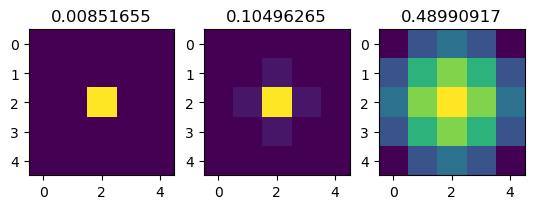

In [ ]:
#| eval: false
import matplotlib.pyplot as plt
kernel = model.return_kernel({"params": params}, c_in=3)
fig, axes = plt.subplots(1, 3)
for k, sigma, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), params["sigma"], axes):
    ax.imshow(k)
    ax.set_title(sigma)
plt.show()

We can test if the precalculated filters are updated when in training mode and stay the same when in evaluation mode:

In [ ]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=True)
assert not jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 115 ms, sys: 13 ms, total: 128 ms
Wall time: 245 ms


In [ ]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=False)
assert jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 13 ms, sys: 675 µs, total: 13.7 ms
Wall time: 11.9 ms


We see that there is a time difference in both executions, which makes sense because when `train=False`, the filters don't have to be calculated and thus the function should run faster.

And let's see if we're able to train the layer weights while maintaining the state:

In [ ]:
from functools import partial

@partial(jax.jit, static_argnums=(0, 1))
def update_step(apply_fn, tx, inputs, opt_state, params, state):
    def loss(params):
        pred, updated_state = apply_fn({"params": params, **state}, 
                                       x, 
                                       mutable=list(state.keys()), 
                                       train=True)
        loss = ((pred-inputs)**2).mean()
        return loss, updated_state
    (l, updated_state), grads = jax.value_and_grad(loss, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, updated_state, l

In [ ]:
model = GaussianLayer(features=3, kernel_size=21, fs=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
del variables  # Delete variables to avoid wasting resources
tx = optax.sgd(learning_rate=3e-4)
opt_state = tx.init(params)

for i in range(1001):
  opt_state, params, state, loss = update_step(
      model.apply, tx, x, opt_state, params, state)
  if i % 100 == 0: print(f"Loss {i}: {loss}")

Loss 0: 63022.4609375
Loss 100: 6.955494403839111
Loss 200: 4.457688331604004
Loss 300: 3.4671144485473633
Loss 400: 2.9231908321380615
Loss 500: 2.575880765914917
Loss 600: 2.3336236476898193
Loss 700: 2.1544978618621826
Loss 800: 2.0164477825164795
Loss 900: 1.906706690788269
Loss 1000: 1.817345380783081


The loss is going down, so everything looking good so far!

## Gabor layer

> We'll repeat the process but now with a Gabor functional form.

In [ ]:
#| export
class GaborLayer(nn.Module):
    """Parametric Gabor layer."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency

    normalize_prob: bool = True
    normalize_energy: bool = False

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        freq = self.param("freq",
                           nn.initializers.uniform(scale=self.fs/2),
                           (self.features*inputs.shape[-1],))
        logsigmax = self.param("logsigmax",
                           bounded_uniform(minval=-4., maxval=-0.5),
                           (self.features*inputs.shape[-1],))
        logsigmay = self.param("logsigmay",
                           bounded_uniform(minval=-4., maxval=-0.5),
                           (self.features*inputs.shape[-1],))        
        theta = self.param("theta",
                           nn.initializers.uniform(scale=jnp.pi),
                           (self.features*inputs.shape[-1],))
        sigma_theta = self.param("sigma_theta",
                           nn.initializers.uniform(scale=jnp.pi),
                           (self.features*inputs.shape[-1],))
        rot_theta = self.param("rot_theta",
                           nn.initializers.uniform(scale=jnp.pi),
                           (self.features*inputs.shape[-1],))
        A = self.param("A",
                       nn.initializers.ones,
                       (self.features*inputs.shape[-1],))
        sigmax, sigmay = jnp.exp(logsigmax), jnp.exp(logsigmay)
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (self.features,))
        else: bias = 0.
        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            # gabor_fn = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,0,0,0,None,None))
            kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,0,0,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, sigmax, sigmay, freq, theta, sigma_theta, rot_theta, A, self.normalize_prob, self.normalize_energy)
            kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
            # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gabor(x, y, xmean, ymean, sigmax, sigmay, freq, theta, sigma_theta, rot_theta, A=1, normalize_prob=True, normalize_energy=False):
        # ## Rotate the dominion
        # x = jnp.cos(rot_theta) * (x - xmean) - jnp.sin(rot_theta) * (y - ymean)
        # y = jnp.sin(rot_theta) * (x - xmean) + jnp.cos(rot_theta) * (y - ymean)
        x, y = x-xmean, y-ymean
        ## Obtain the normalization coeficient
        sigma_vector = jnp.array([sigmax, sigmay])
        cov_matrix = jnp.diag(sigma_vector)**2
        det_cov_matrix = jnp.linalg.det(cov_matrix)
        # A_norm = 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)) if normalize_prob else 1.
        A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)), 1.)
        
        ## Rotate the sinusoid
        rotation_matrix = jnp.array([[jnp.cos(sigma_theta), -jnp.sin(sigma_theta)],
                                     [jnp.sin(sigma_theta), jnp.cos(sigma_theta)]])
        rotated_covariance = rotation_matrix @ jnp.linalg.inv(cov_matrix) @ jnp.transpose(rotation_matrix)
        x_r_1 = rotated_covariance[0,0] * x + rotated_covariance[0,1] * y
        y_r_1 = rotated_covariance[1,0] * x + rotated_covariance[1,1] * y
        distance = x * x_r_1 + y * y_r_1
        g = A_norm*jnp.exp(-distance/2) * jnp.cos(2*jnp.pi*freq*(x*jnp.cos(theta)+y*jnp.sin(theta)))
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return A*g/E_norm

    def return_kernel(self, params, c_in=3):
        x, y = self.generate_dominion()
        sigmax, sigmay = jnp.exp(params["logsigmax"]), jnp.exp(params["logsigmay"])
        # sigmax, sigmay = jnp.exp(params["sigmax"]), jnp.exp(params["sigmay"])
        kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,0,0,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, sigmax, sigmay, params["freq"], params["theta"], params["sigma_theta"], params["rot_theta"], params["A"], self.normalize_prob, self.normalize_energy)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, input_channels, self.features))
        kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=c_in, c_out=self.features)
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size), jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size))

In [ ]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = GaborLayer(features=1, kernel_size=21, fs=21)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    A: (3,),
    freq: (3,),
    logsigmax: (3,),
    logsigmay: (3,),
    rot_theta: (3,),
    sigma_theta: (3,),
    theta: (3,),
})


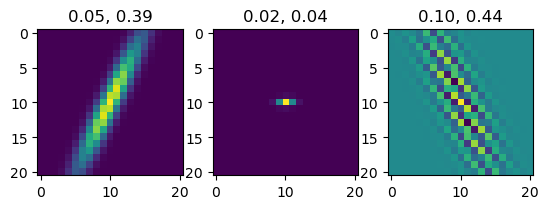

In [ ]:
#| eval: false
import matplotlib.pyplot as plt
kernel = model.return_kernel(params, c_in=3)
fig, axes = plt.subplots(1, 3)
# for k, sigmax, sigmay, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), params["sigmax"], params["sigmay"], axes):
for k, sigmax, sigmay, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), jnp.exp(params["logsigmax"]), jnp.exp(params["logsigmay"]), axes):
    ax.imshow(k)
    ax.set_title(f"{sigmax:.2f}, {sigmay:.2f}")
plt.show()

We can test if the precalculated filters are updated when in training mode and stay the same when in evaluation mode:

In [ ]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=True)
assert not jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 180 ms, sys: 7.57 ms, total: 187 ms
Wall time: 315 ms


In [ ]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=False)
assert jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 31.7 ms, sys: 963 µs, total: 32.7 ms
Wall time: 30.7 ms


We see that there is a time difference in both executions, which makes sense because when `train=False`, the filters don't have to be calculated and thus the function should run faster.

And let's see if we're able to train the layer weights while maintaining the state:

In [ ]:
from functools import partial

@partial(jax.jit, static_argnums=(0, 1))
def update_step(apply_fn, tx, inputs, opt_state, params, state):
    def loss(params):
        pred, updated_state = apply_fn({"params": params, **state}, 
                                       x, 
                                       mutable=list(state.keys()), 
                                       train=True)
        loss = ((pred-inputs)**2).mean()
        return loss, updated_state
    (l, updated_state), grads = jax.value_and_grad(loss, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, updated_state, l

In [ ]:
model = GaborLayer(features=1, kernel_size=21, fs=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
params

FrozenDict({
    freq: Array([ 0.6816269, 10.3780775,  1.1226437], dtype=float32),
    logsigmax: Array([-2.4631429 , -2.717532  , -0.77407956], dtype=float32),
    logsigmay: Array([-3.0342553 , -2.29462   , -0.74401665], dtype=float32),
    theta: Array([3.050746 , 0.9813687, 1.7434841], dtype=float32),
    sigma_theta: Array([2.1122246, 2.7645009, 0.9459793], dtype=float32),
    rot_theta: Array([2.5787003, 1.4155393, 0.6662881], dtype=float32),
    A: Array([1., 1., 1.], dtype=float32),
})

In [ ]:
model = GaborLayer(features=1, kernel_size=21, fs=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
del variables  # Delete variables to avoid wasting resources
tx = optax.sgd(learning_rate=3e-4)
opt_state = tx.init(params)
print(params)

for i in range(1001):
  opt_state, params, state, loss = update_step(
      model.apply, tx, x, opt_state, params, state)
  if i % 100 == 0: print(f"Loss {i}: {loss}")
  # print(f"Loss {i}: {loss}")
  # print(params)

FrozenDict({
    freq: Array([ 0.6816269, 10.3780775,  1.1226437], dtype=float32),
    logsigmax: Array([-2.4631429 , -2.717532  , -0.77407956], dtype=float32),
    logsigmay: Array([-3.0342553 , -2.29462   , -0.74401665], dtype=float32),
    theta: Array([3.050746 , 0.9813687, 1.7434841], dtype=float32),
    sigma_theta: Array([2.1122246, 2.7645009, 0.9459793], dtype=float32),
    rot_theta: Array([2.5787003, 1.4155393, 0.6662881], dtype=float32),
    A: Array([1., 1., 1.], dtype=float32),
})
Loss 0: 10626.98828125
Loss 100: 6.142861366271973
Loss 200: 3.385617256164551
Loss 300: 2.529557943344116
Loss 400: 2.1249473094940186
Loss 500: 1.8925855159759521
Loss 600: 1.7426061630249023
Loss 700: 1.6378673315048218
Loss 800: 1.560482382774353
Loss 900: 1.5008677244186401
Loss 1000: 1.4534565210342407


The loss is going down, so everything looking good so far!

## Center Surround layer

In [ ]:
#| export
class CenterSurroundLogSigma(nn.Module):
    """Parametric center surround layer that optimizes log(sigma) instead of sigma."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    normalize_prob: bool = True
    normalize_energy: bool = False

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        logsigma = self.param("logsigma",
                           bounded_uniform(minval=-2.2, maxval=-1.7),
                           (self.features*inputs.shape[-1],))
        logsigma2 = self.param("logsigma2",
                           bounded_uniform(minval=-2.2, maxval=-1.7),
                           (self.features*inputs.shape[-1],))
        A = self.param("A",
                       nn.initializers.ones,
                       (self.features*inputs.shape[-1],))
        sigma = jnp.exp(logsigma)
        sigma2 = jnp.exp(logsigma2)
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (self.features,))
        else: bias = 0.
        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            kernel = jax.vmap(self.center_surround, in_axes=(None,None,None,None,0,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, sigma, sigma2, A, self.normalize_prob, self.normalize_energy)
            # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    # @staticmethod
    # def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True):
    #     # A_norm = 1/(2*jnp.pi*sigma) if normalize_prob else 1.
    #     A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma), 1.)
    #     return A*A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))
    
    @staticmethod
    def center_surround(x, y, xmean, ymean, sigma, sigma2, A=1, normalize_prob=True, normalize_energy=False):
        def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True):
            A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma**2), 1.)
            return A*A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))
        g1 = gaussian(x, y, xmean, ymean, sigma, 1, normalize_prob)
        g2 = gaussian(x, y, xmean, ymean, sigma2, 1, normalize_prob)
        g = g1-g2
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return A*g/E_norm
    
    # @staticmethod
    # def center_surround(x, y, xmean, ymean, sigma,  K, A=1, normalize_prob=True):
    #     return (1/(2*jnp.pi*sigma**2))*(jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2)) - (1/(K**2))*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*(K*sigma)**2)))

    def return_kernel(self, params, c_in):
        x, y = self.generate_dominion()
        kernel = jax.vmap(self.center_surround, in_axes=(None,None,None,None,0,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, jnp.exp(params["params"]["logsigma"]), jnp.exp(params["params"]["logsigma2"]), params["params"]["A"], self.normalize_prob, self.normalize_energy)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=c_in, c_out=self.features)
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size), jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size))

In [ ]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = CenterSurroundLogSigma(features=1, kernel_size=21, fs=21)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    A: (3,),
    logsigma: (3,),
    logsigma2: (3,),
})


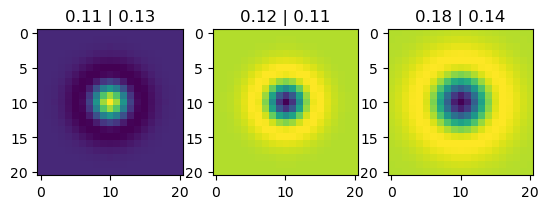

In [ ]:
#| eval: false
import matplotlib.pyplot as plt
kernel = model.return_kernel({"params": params}, c_in=3)
fig, axes = plt.subplots(1, 3)
for k, sigma, sigma2, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), jnp.exp(params["logsigma"]), jnp.exp(params["logsigma2"]), axes):
    ax.imshow(k)
    ax.set_title(f"{sigma:.2f} | {sigma2:.2f}")
plt.show()

In [ ]:
#| export
class CenterSurroundLogSigmaK(nn.Module):
    """Parametric center surround layer that optimizes log(sigma) instead of sigma and has a factor K instead of a second sigma."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    normalize_prob: bool = True
    normalize_energy: bool = True

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        logsigma = self.param("logsigma",
                           bounded_uniform(minval=-2.2, maxval=-1.7),
                           (self.features*inputs.shape[-1],))
        K = self.param("K",
                           displaced_normal(mean=1.1, stddev=0.1),
                           (self.features*inputs.shape[-1],))
        A = self.param("A",
                       nn.initializers.ones,
                       (self.features*inputs.shape[-1],))
        sigma = jnp.exp(logsigma)
        sigma2 = K*sigma
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (self.features,))
        else: bias = 0.
        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            kernel = jax.vmap(self.center_surround, in_axes=(None,None,None,None,0,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, sigma, sigma2, A, self.normalize_prob, self.normalize_energy)
            # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
            kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    # @staticmethod
    # def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True):
    #     # A_norm = 1/(2*jnp.pi*sigma) if normalize_prob else 1.
    #     A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma), 1.)
    #     return A*A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))
    
    @staticmethod
    def center_surround(x, y, xmean, ymean, sigma, sigma2, A=1, normalize_prob=True, normalize_energy=False):
        def gaussian(x, y, xmean, ymean, sigma, A=1, normalize_prob=True):
            A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*sigma**2), 1.)
            return A*A_norm*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))
        g1 = gaussian(x, y, xmean, ymean, sigma, 1, normalize_prob)
        g2 = gaussian(x, y, xmean, ymean, sigma2, 1, normalize_prob)
        g = g1 - g2
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return A*g/E_norm
    
    # @staticmethod
    # def center_surround(x, y, xmean, ymean, sigma,  K, A=1, normalize_prob=True):
    #     return (1/(2*jnp.pi*sigma**2))*(jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2)) - (1/(K**2))*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*(K*sigma)**2)))

    def return_kernel(self, params, c_in):
        x, y = self.generate_dominion()
        kernel = jax.vmap(self.center_surround, in_axes=(None,None,None,None,0,0,0,None,None), out_axes=0)(x, y, self.xmean, self.ymean, jnp.exp(params["params"]["logsigma"]), params["params"]["K"]*jnp.exp(params["params"]["logsigma"]), params["params"]["A"], self.normalize_prob, self.normalize_energy)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=c_in, c_out=self.features)
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size), jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size))

In [ ]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = CenterSurroundLogSigmaK(features=1, kernel_size=21, fs=21)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    A: (3,),
    K: (3,),
    logsigma: (3,),
})


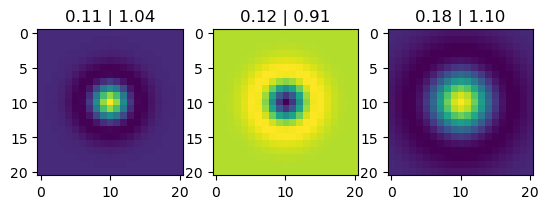

In [ ]:
#| eval: false
import matplotlib.pyplot as plt
kernel = model.return_kernel({"params": params}, c_in=3)
fig, axes = plt.subplots(1, 3)
for k, sigma, K, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), jnp.exp(params["logsigma"]), params["K"], axes):
    ax.imshow(k)
    ax.set_title(f"{sigma:.2f} | {K:.2f}")
plt.show()

We can test if the precalculated filters are updated when in training mode and stay the same when in evaluation mode:

In [ ]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=True)
assert not jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 38.3 ms, sys: 10.8 ms, total: 49.2 ms
Wall time: 43.5 ms


In [ ]:
%%time
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=False)
assert jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 19.4 ms, sys: 3.11 ms, total: 22.5 ms
Wall time: 20.6 ms


We see that there is a time difference in both executions, which makes sense because when `train=False`, the filters don't have to be calculated and thus the function should run faster.

And let's see if we're able to train the layer weights while maintaining the state:

In [ ]:
from functools import partial

@partial(jax.jit, static_argnums=(0, 1))
def update_step(apply_fn, tx, inputs, opt_state, params, state):
    def loss(params):
        pred, updated_state = apply_fn({"params": params, **state}, 
                                       x, 
                                       mutable=list(state.keys()), 
                                       train=True)
        loss = ((pred-inputs)**2).mean()
        return loss, updated_state
    (l, updated_state), grads = jax.value_and_grad(loss, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, updated_state, l

In [ ]:
model = CenterSurroundLogSigmaK(features=3, kernel_size=21, fs=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
del variables  # Delete variables to avoid wasting resources
tx = optax.sgd(learning_rate=3e-4)
opt_state = tx.init(params)

for i in range(1001):
  opt_state, params, state, loss = update_step(
      model.apply, tx, x, opt_state, params, state)
  if i % 100 == 0: print(f"Loss {i}: {loss}")

Loss 0: 3.6969494819641113
Loss 100: 3.5763187408447266
Loss 200: 3.461313486099243
Loss 300: 3.6449344158172607
Loss 400: 3.518977642059326
Loss 500: 3.3996057510375977
Loss 600: 3.287114381790161
Loss 700: 3.179790496826172
Loss 800: 2.8719370365142822
Loss 900: 3.0001907348632812
Loss 1000: 2.9072959423065186


The loss is going down, so everything looking good so far!

## Gabor_

In [ ]:
#| export
class GaborLayer_(nn.Module):
    """Parametric Gabor layer with particular initialization."""
    # features: int
    n_scales: int
    n_orientations: int
    # n_phases: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    phase = jnp.array([0., jnp.pi/2.])

    normalize_prob: bool = True
    normalize_energy: bool = False

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 return_freq=False,
                 return_theta=False,
                 ):
        features = self.n_scales * self.n_orientations * len(self.phase)
        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], features))
        freq = self.param("freq",
                           freq_scales_init(n_scales=self.n_scales, fs=self.fs),
                           (self.n_scales,))
        sigmax = self.param("sigmax",
                           k_array(k=0.4, arr=freq),
                           (self.n_scales,))
        sigmay = self.param("sigmay",
                           equal_to(1.5*sigmax),
                           (self.n_scales,))
        # theta = self.param("theta",
        #                    nn.initializers.uniform(scale=jnp.pi),
        #                    (self.n_scales*self.n_orientations,))
        theta = self.param("theta",
                           linspace(start=0, stop=jnp.pi, num=self.n_orientations),
                           (self.n_orientations,))
        sigma_theta = self.param("sigma_theta",
                           linspace(start=0, stop=jnp.pi, num=self.n_orientations),
                           (self.n_orientations,))
        # sigma_theta = theta - jnp.pi/2.
        # A = self.param("A",
        #                nn.initializers.ones,
        #                (self.features*inputs.shape[-1],))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (features,))
        else: bias = 0.
        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None), out_axes=0)
            # kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,0,None,None,None,None,None,None), out_axes=0)
            kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None), out_axes=0)
            kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, sigmax, sigmay, freq, theta, sigma_theta, self.phase, 1, self.normalize_prob, self.normalize_energy)
            kernel = rearrange(kernel, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
            kernel = repeat(kernel, "kx ky c_out -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=kernel.shape[-1])
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        if return_freq and return_theta:
            return outputs + bias, freq, theta
        elif return_freq and not return_theta:
            return outputs + bias, freq
        elif not return_freq and return_theta:
            return outputs + bias, theta
        else:
            return outputs + bias

    @staticmethod
    def gabor(x, y, xmean, ymean, sigmax, sigmay, freq, theta, sigma_theta, phase, A=1, normalize_prob=True, normalize_energy=False):
        x, y = x-xmean, y-ymean
        ## Obtain the normalization coeficient
        sigma_vector = jnp.array([sigmax, sigmay])
        cov_matrix = jnp.diag(sigma_vector)**2
        det_cov_matrix = jnp.linalg.det(cov_matrix)
        # A_norm = 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)) if normalize_prob else 1.
        A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)), 1.)
        
        ## Rotate the sinusoid
        rotation_matrix = jnp.array([[jnp.cos(sigma_theta), -jnp.sin(sigma_theta)],
                                     [jnp.sin(sigma_theta), jnp.cos(sigma_theta)]])
        rotated_covariance = rotation_matrix @ jnp.linalg.inv(cov_matrix) @ jnp.transpose(rotation_matrix)
        x_r_1 = rotated_covariance[0,0] * x + rotated_covariance[0,1] * y
        y_r_1 = rotated_covariance[1,0] * x + rotated_covariance[1,1] * y
        distance = x * x_r_1 + y * y_r_1
        g = A_norm*jnp.exp(-distance/2) * jnp.cos(2*jnp.pi*freq*(x*jnp.cos(theta)+y*jnp.sin(theta)) + phase)
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return A*g/E_norm

    def return_kernel(self, params, c_in=3):
        x, y = self.generate_dominion()
        sigmax, sigmay = jnp.exp(params["sigmax"]), jnp.exp(params["sigmay"])
        kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,None,None,None,None,None,None,None), out_axes=0)
        kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,0,None,None,None,None,None,None), out_axes=0)
        kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,0,0,0,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, params["sigmax"], params["sigmay"], params["freq"], params["theta"], params["sigma_theta"], self.phase, 1, self.normalize_prob, self.normalize_energy)
        # kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
        kernel = rearrange(kernel, "rots fs sigmas kx ky -> kx ky (rots fs sigmas)")
        kernel = repeat(kernel, "kx ky c_out -> kx ky c_in c_out", c_in=c_in, c_out=kernel.shape[-1])
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size), jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size))

In [ ]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = GaborLayer_(n_scales=4, n_orientations=10, kernel_size=64, fs=64, normalize_prob=True, normalize_energy=False)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    freq: (4,),
    sigma_theta: (10,),
    sigmax: (4,),
    sigmay: (4,),
    theta: (10,),
})


In [ ]:
params

FrozenDict({
    freq: Array([24., 12.,  6.,  3.], dtype=float32),
    sigmax: Array([0.01666667, 0.03333334, 0.06666667, 0.13333334], dtype=float32),
    sigmay: Array([0.025     , 0.05      , 0.10000001, 0.20000002], dtype=float32),
    theta: Array([0.        , 0.31415927, 0.62831855, 0.9424778 , 1.2566371 ,
           1.5707964 , 1.8849556 , 2.1991148 , 2.5132742 , 2.8274336 ],      dtype=float32),
    sigma_theta: Array([0.        , 0.31415927, 0.62831855, 0.9424778 , 1.2566371 ,
           1.5707964 , 1.8849556 , 2.1991148 , 2.5132742 , 2.8274336 ],      dtype=float32),
})

In [ ]:
x, y = model.generate_dominion()
kernel = jax.vmap(GaborLayer_.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None), out_axes=0)
# kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,0,None,None,None,None,None,None), out_axes=0)
kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None), out_axes=0)
kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None), out_axes=0)(x, y, model.xmean, model.ymean, params["sigmax"], params["sigmay"], params["freq"], params["theta"], params["sigma_theta"], model.phase, 1, model.normalize_prob, model.normalize_energy)
# kernel = rearrange(kernel, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
# kernel = repeat(kernel, "kx ky c_out -> kx ky c_in c_out", c_in=3, c_out=kernel.shape[-1])
kernel.shape

(2, 10, 4, 64, 64)

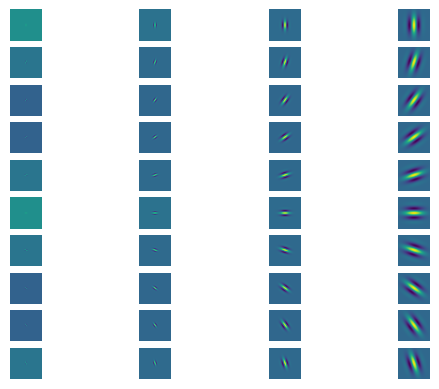

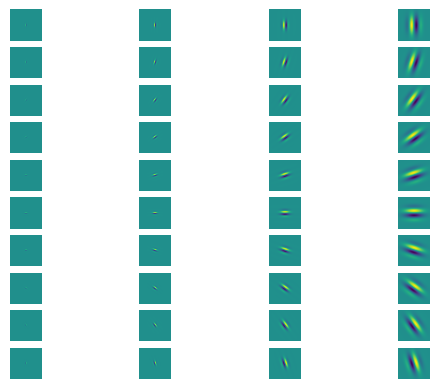

In [ ]:
fig, axes = plt.subplots(kernel.shape[1],kernel.shape[2])
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(kernel[0,i,j])
        ax.axis("off")
plt.show()

fig, axes = plt.subplots(kernel.shape[1],kernel.shape[2])
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(kernel[1,i,j])
        ax.axis("off")
plt.show()

In [ ]:
kernel_f = rearrange(kernel[1:2], "phases rots fs_sigmas kx ky -> (phases rots fs_sigmas) kx ky")
kernel_f.shape

(40, 64, 64)

In [ ]:
kernel_f_fft = jnp.fft.fftn(kernel_f)
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=0)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((40, 64, 64), (64, 64))

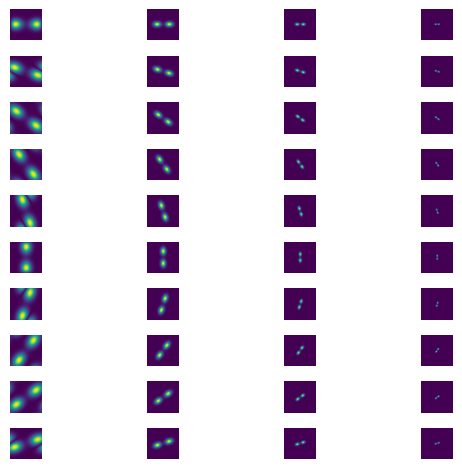

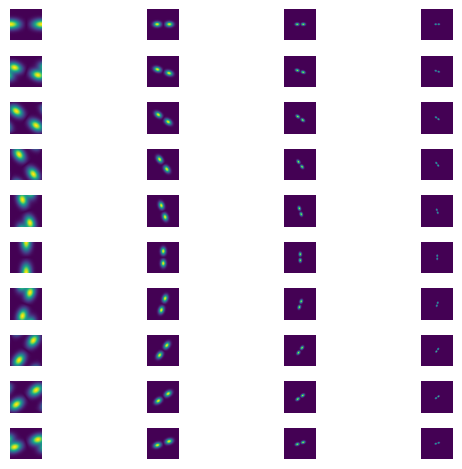

In [ ]:
fig, axes = plt.subplots(kernel.shape[1],kernel.shape[2])
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(jnp.abs(jnp.fft.fftshift(jnp.fft.fftn(kernel[0,i,j]))))
        ax.axis("off")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(kernel.shape[1],kernel.shape[2])
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(jnp.abs(jnp.fft.fftshift(jnp.fft.fftn(kernel[1,i,j]))))
        ax.axis("off")
plt.tight_layout()
plt.show()

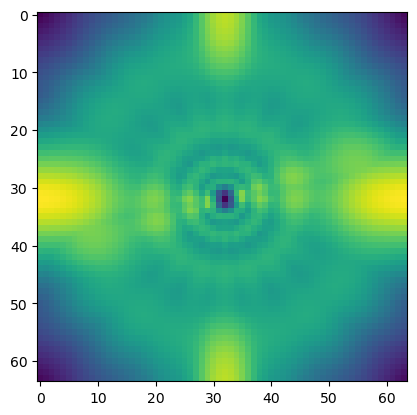

In [ ]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()

In [ ]:
# #| eval: false
# import matplotlib.pyplot as plt
# kernel = model.return_kernel(params, c_in=3)
# fig, axes = plt.subplots(1, 3)
# # for k, sigmax, sigmay, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), params["sigmax"], params["sigmay"], axes):
# for k, sigmax, sigmay, ax in zip(rearrange(kernel, "kx ky cin cout -> (cin cout) kx ky"), jnp.exp(params["sigmax"]), jnp.exp(params["sigmay"]), axes):
#     ax.imshow(k)
#     ax.set_title(f"{sigmax:.2f}, {sigmay:.2f}")
# plt.show()

## J & H

In [ ]:
#| export
class JamesonHurvich(nn.Module):
    """Jameson & Hurvich transformation from RGB to ATD."""

    def setup(self):
        self.Mng2xyz = jnp.array([[69.1661, 52.4902, 46.6052],
                                  [39.0454, 115.8404, 16.3118],
                                  [3.3467, 12.6700, 170.1090]])
        self.Mxyz2atd = jnp.array([[0, 1, 0],
                                   [1, -1, 0],
                                   [0, 0.4, -0.4]])

    def __call__(self,
                 inputs, # (B,H,W,C)
                 **kwargs,
                 ):
        outputs = inputs**2
        outputs = inputs @ self.Mng2xyz.T @ self.Mxyz2atd.T
        return outputs

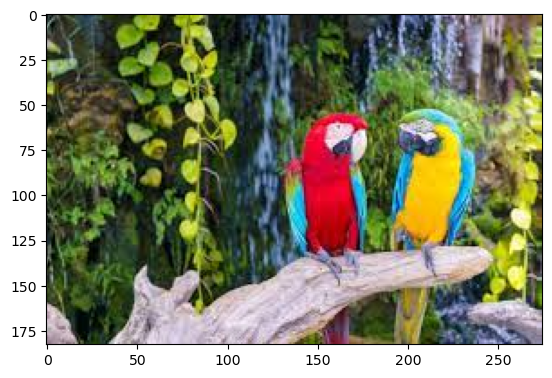

In [ ]:
#| eval: false

import cv2
loros = cv2.imread("loros.jpeg")
loros = cv2.cvtColor(loros, cv2.COLOR_BGR2RGB) / 255.0
plt.imshow(loros)
plt.show()

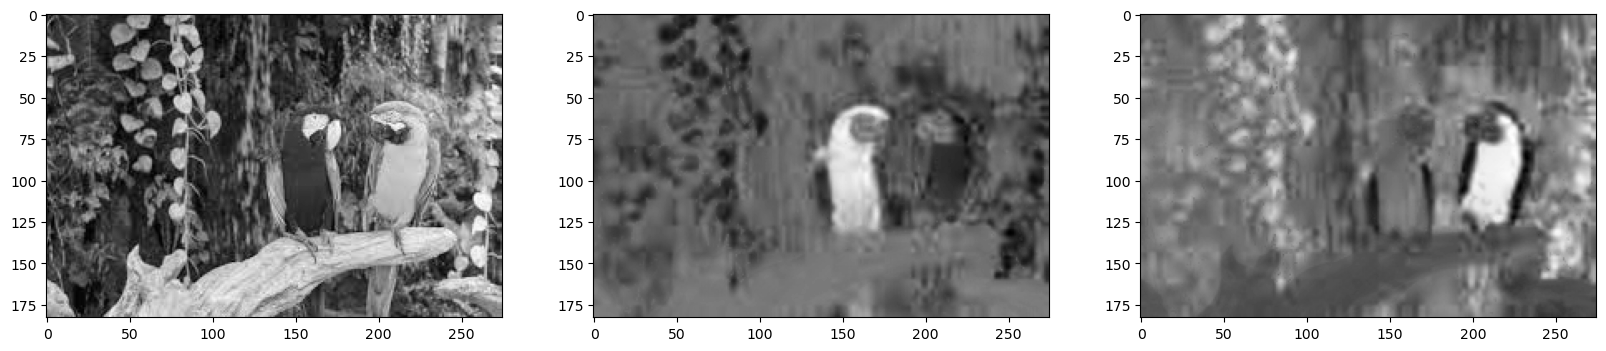

In [ ]:
#| eval: false
T = JamesonHurvich()
pred = T.apply({"params":{"":[]}}, loros)
fig, axes = plt.subplots(1,3, figsize=(20,4))
for i, ax in enumerate(axes):
    ax.imshow(pred[:,:,i], cmap="gray")
plt.show()

## CSF

In [ ]:
#| exporti
def metefot(sec, foto, N, ma):
    ss = foto.shape
    fil = ss[0]
    col = ss[1]
    s = sec.shape
    Nfot = s[1] / col

    if N > Nfot:
        sec = [sec, foto]
    else:
        if ma == 1:
            sec = sec.at[:, (N-1)*col:N*col].set(foto)
    # if incorrect results finish this function.
    return sec

In [ ]:
#| exporti
def freqspace(N):
    # Returns 2-d frequency range vectors for N[0] x N[1] matrix

    f1 = (jnp.arange(0, N[0], 1)-jnp.floor(N[0]/2))*(2/N[0])
    f2 = (jnp.arange(0, N[1], 1)-jnp.floor(N[1]/2))*(2/N[1])
    F1, F2 = jnp.meshgrid(f1, f2)
    return F1, F2

In [ ]:
#| exporti
def spatio_temp_freq_domain(Ny, Nx, Nt, fsx, fsy, fst):
    int_x = Nx/fsx # Physical domain
    int_y = Ny/fsy
    int_t = Nt/fst

    x = jnp.zeros((Ny, Nx*Nt)) # Big matrix
    y = jnp.zeros((Ny, Nx*Nt))
    t = jnp.zeros((Ny, Nx*Nt))

    fot_x = jnp.linspace(0, int_x, Nx+1)
    fot_x = fot_x[:-1]
    fot_x = fot_x[None,:].repeat(Ny, 0)

    fot_y = jnp.linspace(0, int_y, Ny+1)
    fot_y = fot_y[:-1]
    fot_y = fot_y[:,None].repeat(Nx, 1)

    fot_t = jnp.ones((Ny, Nx))

    val_t = jnp.linspace(0, int_t, Nt+1)
    val_t = val_t[:-1]

    for i in range(Nt):
        x = metefot(x, fot_x, i+1, 1)
        y = metefot(y, fot_y, i+1, 1)
        t = metefot(t, val_t[i]*fot_t, i+1, 1)

    [fx, fy] = freqspace([Nx, Ny])

    fx = fx*fsx/2
    fy = fy*fsy/2

    ffx = jnp.zeros((Ny, Nx*Nt))
    ffy = jnp.zeros((Ny, Nx*Nt))
    ff_t = jnp.zeros((Ny, Nx*Nt))

    fot_fx = fx
    fot_fy = fy
    fot_t = jnp.ones((Ny, Nx))

    [ft, ft2] = freqspace([Nt, Nt])
    val_t = ft*fst/2

    for i in range(Nt):
        ffx = metefot(ffx, fot_fx, i+1, 1)
        ffy = metefot(ffy, fot_fy, i+1, 1)
        ff_t = metefot(ff_t, val_t[0,:][i]*fot_t, i+1, 1)

    return x, y, t, ffx, ffy, ff_t

In [ ]:
#| export
class CSFFourier(nn.Module):
    """CSF SSO."""
    fs: int = 64
    norm_energy: bool = True

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        alpha_achrom = self.param("alpha_achrom",
                                  equal_to(1.),
                                  (1,))
        alpha_chrom_rg = self.param("alpha_chrom_rg",
                                 equal_to(1.),
                                 (1,))
        alpha_chrom_yb = self.param("alpha_chrom_yb",
                                 equal_to(1.),
                                 (1,))
        beta_achrom = self.param("beta_achrom",
                          equal_to(1.),
                          (1,))
        beta_chrom = self.param("beta_chrom",
                          equal_to(1.),
                          (1,))
        fm = self.param("fm",
                        equal_to(7.28),
                        (1,))
        s = self.param("s",
                       equal_to(1.809),
                       (1,))
        
        b, h, w, c = inputs.shape

        ## 1. Achromatic CSF
        # csf, fx, fy = jax.jit(self.csf_sso, static_argnums=(1,2))(fs=self.fs, Nx=w, Ny=h, alpha=alpha_achrom, beta=beta_achrom, g=330.74, fm=fm, l=0.837, s=s, w=1.0, os=6.664)
        csf, fx, fy = self.csf_sso(fs=self.fs, Nx=w, Ny=h, alpha=alpha_achrom, beta=beta_achrom, g=330.74, fm=fm, l=0.837, s=s, w=1.0, os=6.664)

        # jax.debug.print(f"Nx={w}, Ny={h}, {csf.shape}")
        ## 2. Chromatic CSFs
        # csfrg, csfyb, fx, fy = jax.jit(self.csf_chrom, static_argnums=(1,2))(fs=self.fs, Nx=w, Ny=h, alpha_rg=alpha_chrom_rg, alpha_yb=alpha_chrom_yb, beta=beta_chrom)
        csfrg, csfyb, fx, fy = self.csf_chrom(fs=self.fs, Nx=w, Ny=h, alpha_rg=alpha_chrom_rg, alpha_yb=alpha_chrom_yb, beta=beta_chrom)
        # jax.debug.print(f"Nx={w}, Ny={h}, {csf.shape}, {csfrg.shape}, {csfyb.shape}")

        ## 3. Stack the three CSFs together
        csfs = jnp.stack([csf, csfrg, csfyb], axis=-1)

        ## 4. FFT of the input
        inputs_fft = jnp.fft.fft2(inputs, axes=(1,2))
        inputs_fft = jnp.fft.fftshift(inputs_fft)
        
        ## 5. Apply the CSF by multiplying
        E1 = jnp.sum(jnp.ones_like(csfs)**2)#**(1/2)
        E_CSF = jnp.sum(csfs**2)#**(1/2)
        if self.norm_energy: csfs = (csfs/E_CSF)*E1
        inputs_fft = csfs[None,:]*inputs_fft

        ## 6. Return to the original domain
        outputs = jnp.fft.ifft2(jnp.fft.ifftshift(inputs_fft), axes=(1,2))
        outputs = jnp.real(outputs)
        
        return outputs
    
    @staticmethod
    def csf_sso(fs, Nx, Ny, alpha, beta, g=330.74, fm=7.28, l=0.837, s=1.809, w=1.0, os=6.664):

        [_,_,_,fx,fy,_] = spatio_temp_freq_domain(Nx=Nx, Ny=Ny, Nt=1, fsx=fs, fsy=fs, fst=1)
        fx, fy = fx*beta, fy*beta
        f = jnp.sqrt(jnp.clip(fx**2 + fy**2, a_min=0.0001))
        # f = f.at[f == 0].set(0.0001)

        CSFT = g * (jnp.exp(-(f/fm)) - l*jnp.exp(-(f**2/s**2)))
        OE = 1 - w*(4*(1-jnp.exp(-(f/os)))*fx**2 *fy**2)/(f**4)
        CSFSSO = alpha*(CSFT * OE)

        return CSFSSO, fx, fy
    
    @staticmethod
    def csf_chrom(fs, Nx, Ny, alpha_rg, alpha_yb, beta):

        def sigm1d(x,x0,s):
            y = 1/(1+jnp.exp((x-x0)/s))
            return y
        
        def umbinc3(c,cu,k,m,alf,sig):
            umb = (cu-k*cu**m)*(1/(1+jnp.exp(jnp.log10(c/(alf*cu))/sig)))+(k*c**m)*(1-1/(1+jnp.exp(jnp.log10(c/(0.9*cu))/(sig/2))))
            return umb
        
        # def iafrg(f, C, facfrec, nolin):
        #     f = facfrec*f
        #     f = jnp.clip(f, a_min=0.00001)
        #     C = jnp.clip(C, a_min=0.0000001)

        #     lf = len(f)
        #     lc = len(C)

        #     #iaf = np.zeros(lf,lc)
        #     ace = jnp.zeros((lf,lc))
        #     p = [0.0840, 0.8345, 0.6313, 0.2077]

        #     if len(nolin)==1:
        #         nolin = [nolin, nolin]

        #     nolini = nolin
        #     nolin = nolini[0]

        #     if ((nolini[0]==0)&(nolini[1]==1)):
        #         nolin=1


        #     if nolin==1:
        #         for i in range(lf):
        #             cu = 1/(100*2537.9*sigm1d(f[i],-55.94,6.64))
        #             ace[i,:] = umbinc3(C,cu,p[0],p[1],p[2],p[3])

        #         iaf = 1/ace

        #     else:
        #         iaf=100*2537.9*sigm1d(f,-55.94,6.64)
        #         iaf=iaf*jnp.ones((1,len(C)))

        #     csfrg=iaf[0,:]

        #     if ((nolini[0]==0)&(nolini[1]==1)):
        #         s = iaf.shape
        #         iafc = jnp.sum(iaf)
        #         iaf = iafc*jnp.ones((1,s[1]))

        #     return iaf, csfrg
        
        def iafrg(f, C, facfrec, nolin, lenf, lenC):
            f = facfrec*f
            f = jnp.clip(f, a_min=0.00001)
            C = jnp.clip(C, a_min=0.0000001)

            # lf = len(f)
            # lc = len(C)
            lf, lc = lenf, lenC

            #iaf = np.zeros(lf,lc)
            ace = jnp.zeros((lf,lc))
            p = [0.0840, 0.8345, 0.6313, 0.2077]

            # if len(nolin)==1:
            #     nolin = [nolin, nolin]

            nolini = nolin
            nolin = nolini[0]

            # if ((nolini[0]==0)&(nolini[1]==1)):
            #     nolin=1


            # if nolin==1:
            #     for i in range(lf):
            #         cu = 1/(100*2537.9*sigm1d(f[i],-55.94,6.64))
            #         ace[i,:] = umbinc3(C,cu,p[0],p[1],p[2],p[3])

            #     iaf = 1./ace

            # else:
            iaf=100*2537.9*sigm1d(f,-55.94,6.64)
            iaf=iaf*jnp.ones((1,len(C)))

            csfrg=iaf[0,:]

            # if ((nolini[0]==0)&(nolini[1]==1)):
            s = iaf.shape
            iafc = jnp.sum(iaf)
            iaf = iafc*jnp.ones((1,s[1]))

            return iaf, csfrg

        def iafyb(f, C, facfrec, nolin, lenf, lenC):
            f = facfrec*f
            f = jnp.clip(f, a_min=0.00001)
            C = jnp.clip(C, a_min=0.0000001)

            # lf = len(f)
            # lc = len(C)
            lf, lc = lenf, lenC

            #iaf = np.zeros(lf,lc)
            ace = jnp.zeros((lf,lc))
            p = [0.1611, 1.3354, 0.3077, 0.7746]

            # if len(nolin)==1:
            #     nolin = [nolin, nolin]

            nolini = nolin
            nolin = nolini[0]

            # if ((nolini[0]==0)&(nolini[1]==1)):
            #     nolin=1

            # if nolin==1:
            #     for i in range(lf):
            #         cu=1/(100*719.7*sigm1d(f[i],-31.72,4.13))
            #         ace[i,:]=umbinc3(C,cu,p[0],p[1],p[2],p[3])

            #     iaf = 1/ace

            # else:
            iaf=100*719.7*sigm1d(f,-31.72,4.13)
            iaf=iaf*jnp.ones((1,len(C)))

            csfyb=iaf[0,:]

            # if ((nolini[0]==0)&(nolini[1]==1)):
            s=iaf.shape
            iafc=jnp.sum(iaf)
            iaf=iafc*jnp.ones((1,s[1]))
            
            return iaf, csfyb

        [_,_,_,fx,fy,_] = spatio_temp_freq_domain(Nx=Nx, Ny=Ny, Nt=1, fsx=fs, fsy=fs, fst=1)
        fx, fy = fx*beta, fy*beta
        # f = jnp.sqrt(fx**2 + fy**2)
        f = jnp.sqrt(jnp.clip(fx**2 + fy**2, a_min=0.0001))
        #f[f == 0] = 0.0001

        csfrg = jnp.zeros((Ny,Nx))
        csfyb = jnp.zeros((Ny,Nx))

        for i in range(Ny):
            [iaf_rg, csf_c] = iafrg(f[i,:], jnp.array([0.1]), 1., jnp.array([0., 0., 0.]), len(f[i,:]), len(jnp.array([0.1])))
            # jax.debug.print(f"{csfrg.shape} / {csf_c.shape}")
            csfrg = csfrg.at[i,:].set(csf_c)

            [iaf_yb, csf_c] = iafyb(f[i,:], jnp.array([0.1]), 1., jnp.array([0., 0., 0.]), len(f[i,:]), len(jnp.array([0.1])))
            csfyb = csfyb.at[i,:].set(csf_c)

        fact_rg = 0.75
        fact_yb = 0.55
        max_CSF_achro = 201.3

        csfrg = fact_rg*max_CSF_achro*csfrg/jnp.max(csfrg)
        csfyb = fact_yb*max_CSF_achro*csfyb/jnp.max(csfyb)

        return alpha_rg*csfrg, alpha_yb*csfyb, fx, fy

In [ ]:
model = CSFFourier()
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(1,28,29,3))
variables = model.init(key2, x)
state, params = variables.pop("params")

In [ ]:
def forward(params, inputs):
    return model.apply({"params": params}, inputs)

In [ ]:
_ = forward(params, x)
_ = jax.jit(forward)(params, x)

In [ ]:
from functools import partial

In [ ]:
f = jax.jit(model.csf_sso, static_argnums=(1,2))
f(fs=64, Nx=4, Ny=4, alpha=1., beta=1.)
f(fs=64, Nx=6, Ny=6, alpha=1., beta=1.)

(Array([[7.4208830e-04, 2.5290015e-01, 2.0652041e+00, 4.0784965e+00,
         2.0652041e+00, 2.5290015e-01],
        [2.5290015e-01, 5.6689572e-02, 4.7199564e+00, 1.7653423e+01,
         4.7199564e+00, 5.6689572e-02],
        [2.0652041e+00, 4.7199564e+00, 4.3300481e+00, 7.6411346e+01,
         4.3300481e+00, 4.7199564e+00],
        [4.0784965e+00, 1.7653423e+01, 7.6411346e+01, 5.3465088e+01,
         7.6411346e+01, 1.7653423e+01],
        [2.0652041e+00, 4.7199564e+00, 4.3300481e+00, 7.6411346e+01,
         4.3300481e+00, 4.7199564e+00],
        [2.5290015e-01, 5.6689572e-02, 4.7199564e+00, 1.7653423e+01,
         4.7199564e+00, 5.6689572e-02]], dtype=float32),
 Array([[-32.      , -21.333334, -10.666667,   0.      ,  10.666667,
          21.333334],
        [-32.      , -21.333334, -10.666667,   0.      ,  10.666667,
          21.333334],
        [-32.      , -21.333334, -10.666667,   0.      ,  10.666667,
          21.333334],
        [-32.      , -21.333334, -10.666667,   0.      ,

In [ ]:
@partial(jax.jit, static_argnums=(0,1))
def test(Nx, Ny):
    return model.csf_sso(fs=64, Nx=Nx, Ny=Ny, alpha=1., beta=1.)
test(Nx=4, Ny=4)
test(Nx=6, Ny=6)

(Array([[7.4208830e-04, 2.5290015e-01, 2.0652041e+00, 4.0784965e+00,
         2.0652041e+00, 2.5290015e-01],
        [2.5290015e-01, 5.6689572e-02, 4.7199564e+00, 1.7653423e+01,
         4.7199564e+00, 5.6689572e-02],
        [2.0652041e+00, 4.7199564e+00, 4.3300481e+00, 7.6411346e+01,
         4.3300481e+00, 4.7199564e+00],
        [4.0784965e+00, 1.7653423e+01, 7.6411346e+01, 5.3465088e+01,
         7.6411346e+01, 1.7653423e+01],
        [2.0652041e+00, 4.7199564e+00, 4.3300481e+00, 7.6411346e+01,
         4.3300481e+00, 4.7199564e+00],
        [2.5290015e-01, 5.6689572e-02, 4.7199564e+00, 1.7653423e+01,
         4.7199564e+00, 5.6689572e-02]], dtype=float32),
 Array([[-32.      , -21.333334, -10.666667,   0.      ,  10.666667,
          21.333334],
        [-32.      , -21.333334, -10.666667,   0.      ,  10.666667,
          21.333334],
        [-32.      , -21.333334, -10.666667,   0.      ,  10.666667,
          21.333334],
        [-32.      , -21.333334, -10.666667,   0.      ,

In [ ]:
f = jax.jit(model.csf_chrom, static_argnums=(1,2))
# f = jax.jit(model.csf_chrom)
f(fs=64, Nx=4, Ny=4, alpha_rg=1., alpha_yb=1., beta=1.)
f(fs=64, Nx=6, Ny=6, alpha_rg=1., alpha_yb=1., beta=1.)

(Array([[  0.1658539 ,   0.46152785,   0.940704  ,   1.220865  ,
           0.940704  ,   0.46152785],
        [  0.46152785,   1.6083002 ,   4.1651654 ,   6.0859256 ,
           4.1651654 ,   1.6083002 ],
        [  0.940704  ,   4.1651654 ,  15.595571  ,  30.33703   ,
          15.595571  ,   4.1651654 ],
        [  1.220865  ,   6.0859256 ,  30.33703   , 150.97502   ,
          30.33703   ,   6.0859256 ],
        [  0.940704  ,   4.1651654 ,  15.595571  ,  30.33703   ,
          15.595571  ,   4.1651654 ],
        [  0.46152785,   1.6083002 ,   4.1651654 ,   6.0859256 ,
           4.1651654 ,   1.6083002 ]], dtype=float32),
 Array([[1.9348152e-03, 1.0028565e-02, 3.1509679e-02, 4.7914241e-02,
         3.1509679e-02, 1.0028565e-02],
        [1.0028565e-02, 7.4629605e-02, 3.4461936e-01, 6.3405633e-01,
         3.4461936e-01, 7.4629605e-02],
        [3.1509679e-02, 3.4461936e-01, 2.8785884e+00, 8.3903189e+00,
         2.8785884e+00, 3.4461936e-01],
        [4.7914241e-02, 6.3405633e-01,

In [ ]:
partial(jax.jit, static_argnums=(0,1))
def test(Nx, Ny):
    return model.csf_chrom(fs=64, Nx=Nx, Ny=Ny, alpha_rg=1., alpha_yb=1., beta=1)
test(Nx=4, Ny=4)
test(Nx=6, Ny=6)

(Array([[  0.1658539 ,   0.46152785,   0.940704  ,   1.220865  ,
           0.940704  ,   0.46152785],
        [  0.46152785,   1.6083002 ,   4.1651654 ,   6.0859256 ,
           4.1651654 ,   1.6083002 ],
        [  0.940704  ,   4.1651654 ,  15.595571  ,  30.33703   ,
          15.595571  ,   4.1651654 ],
        [  1.220865  ,   6.0859256 ,  30.33703   , 150.97502   ,
          30.33703   ,   6.0859256 ],
        [  0.940704  ,   4.1651654 ,  15.595571  ,  30.33703   ,
          15.595571  ,   4.1651654 ],
        [  0.46152785,   1.6083002 ,   4.1651654 ,   6.0859256 ,
           4.1651654 ,   1.6083002 ]], dtype=float32),
 Array([[1.9348152e-03, 1.0028565e-02, 3.1509679e-02, 4.7914241e-02,
         3.1509679e-02, 1.0028565e-02],
        [1.0028565e-02, 7.4629605e-02, 3.4461936e-01, 6.3405633e-01,
         3.4461936e-01, 7.4629605e-02],
        [3.1509679e-02, 3.4461936e-01, 2.8785884e+00, 8.3903189e+00,
         2.8785884e+00, 3.4461936e-01],
        [4.7914241e-02, 6.3405633e-01,

In [ ]:
T = JamesonHurvich()
loros_atd = T.apply({"params":{"":[]}}, loros)

In [ ]:
pred = model.apply({"params": params}, loros_atd[None,:])
pred.shape

(1, 183, 275, 3)

In [ ]:
Mng2xyz = jnp.array([[69.1661, 52.4902, 46.6052],
                                  [39.0454, 115.8404, 16.3118],
                                  [3.3467, 12.6700, 170.1090]])
Mxyz2atd = jnp.array([[0, 1, 0],
                            [1, -1, 0],
                            [0, 0.4, -0.4]])
Mxyz2ng = jnp.linalg.inv(Mng2xyz)
Matd2xyz = jnp.linalg.inv(Mxyz2atd)

In [ ]:
pred_rg = (pred @ Matd2xyz.T @ Mxyz2ng.T)**(1/2)
pred_rg.shape

(1, 183, 275, 3)

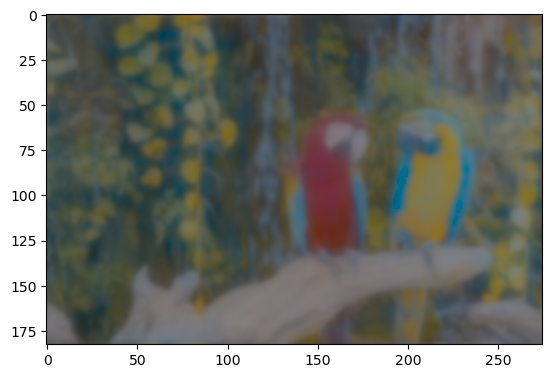

In [ ]:
plt.imshow(pred_rg[0])
plt.show()

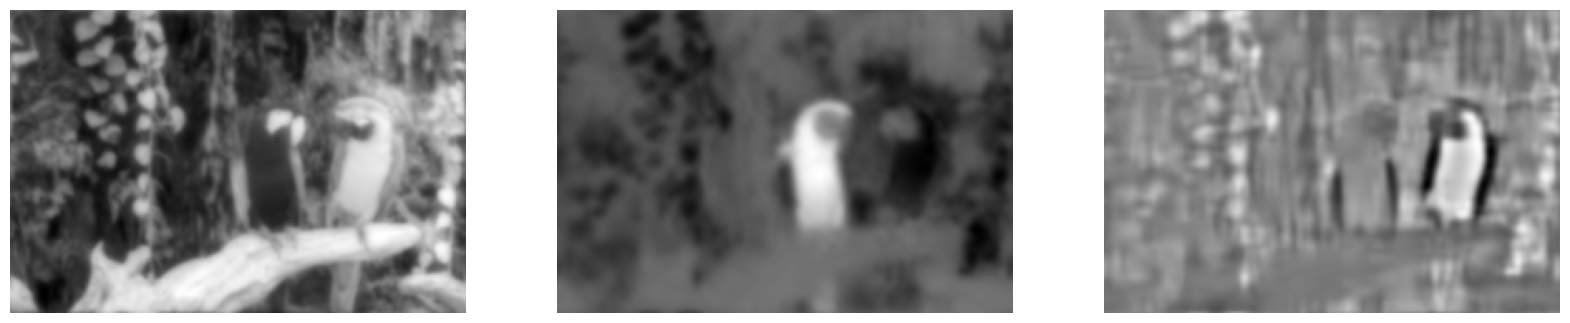

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(20,4))
for i in range(3):
    axes[i].imshow(pred[0][:,:,i], cmap="gray")
    axes[i].axis("off")
plt.show()

In [ ]:
def step(params):
    pred = model.apply({"params": params}, loros_atd[None,:])
    return jnp.mean((pred - loros_atd[None,:])**2)

In [ ]:
@jax.jit
def train_step(params, image, lr=3e-4):
    def step(params):
        pred = model.apply(params, image)
        return jnp.mean((pred - image)**2)
    
    loss, grad = jax.value_and_grad(step)(params)
    params = jax.tree_util.tree_map(lambda p,g: p - lr*g, params, grad)
    return params, loss

In [ ]:
#| eval: false
lr = 3e-4
params_ = {"params": params}
for it in range(N_ITERS:=3):
    params_, loss = train_step(params_, loros_atd[None,:], lr=lr)
    print(f"It: {it} -> {loss}")
params_

It: 0 -> 1214.27734375
It: 1 -> 273.94989013671875
It: 2 -> 497.3630676269531


{'params': FrozenDict({
     alpha_achrom: Array(1.1354797, dtype=float32),
     alpha_chrom_rg: Array(1.316926, dtype=float32),
     alpha_chrom_yb: Array(1.0976608, dtype=float32),
     beta_achrom: Array(1.2981634, dtype=float32),
     beta_chrom: Array(0.5935609, dtype=float32),
     fm: Array(7.2472496, dtype=float32),
     s: Array(1.8248081, dtype=float32),
 })}

In [ ]:
#| eval: false
lr = 3e-4
params_ = params
for it in range(N_ITERS:=3):
    loss, grad = jax.value_and_grad(step)(params_)
    params_ = jax.tree_util.tree_map(lambda p,g: p - lr*g, params_, grad)
    print(f"It: {it} -> {loss}")
params_

It: 0 -> 1214.27734375
It: 1 -> 273.9499206542969
It: 2 -> 497.36279296875


FrozenDict({
    alpha_achrom: Array(1.1354793, dtype=float32),
    alpha_chrom_rg: Array(1.3169256, dtype=float32),
    alpha_chrom_yb: Array(1.0976607, dtype=float32),
    beta_achrom: Array(1.2981635, dtype=float32),
    beta_chrom: Array(0.5935616, dtype=float32),
    fm: Array(7.2472496, dtype=float32),
    s: Array(1.8248082, dtype=float32),
})

In [ ]:
## DN después de la CSF
# b = 0.04 [0-1]
# sigma = 0.02 (deg)

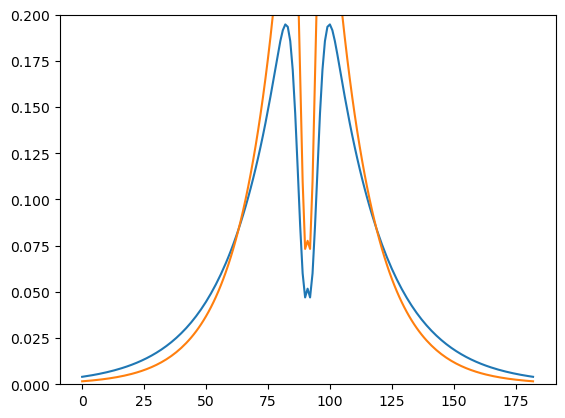

In [ ]:
fs = 64
Nx, Ny = loros[None,:].shape[1:3]
alpha = 1.
beta = 1.
# for beta in [10., 1., 0.8, 0.5, 0.01, 0.]:
for p in [params, params_]:
    csf, _, _ = model.csf_sso(fs, Nx, Ny, p["alpha_achrom"], p["beta_achrom"], g=330.74, fm=p["fm"], l=0.837, s=p["s"], w=1.0, os=6.664)
    E1 = jnp.sum(jnp.ones_like(csf)**2)#**(1/2)
    E_CSF = jnp.sum(csf**2)#**(1/2)
    csf = (csf/E_CSF)*E1
    plt.plot(csf[csf.shape[0]//2], label=beta)
# plt.legend()
plt.ylim([0,0.2])
plt.show()

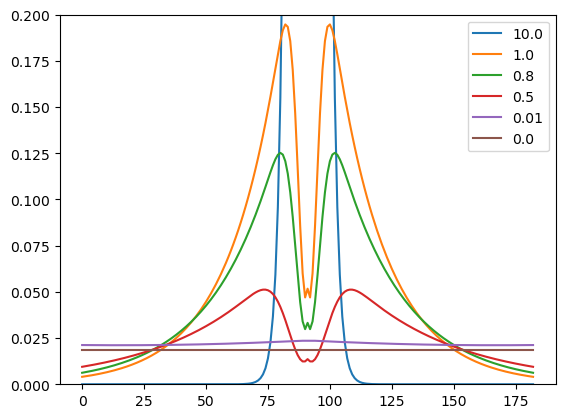

In [ ]:
fs = 64
Nx, Ny = loros[None,:].shape[1:3]
alpha = 1.
beta = 1.
for beta in [10., 1., 0.8, 0.5, 0.01, 0.]:
    csf, _, _ = model.csf_sso(fs, Nx, Ny, alpha, beta, g=330.74, fm=7.28, l=0.837, s=1.809, w=1.0, os=6.664)
    E1 = jnp.sum(jnp.ones_like(csf)**2)#**(1/2)
    E_CSF = jnp.sum(csf**2)#**(1/2)
    csf = (csf/E_CSF)*E1
    plt.plot(csf[csf.shape[0]//2], label=beta)
plt.legend()
plt.ylim([0,0.2])
plt.show()

## GDN

In [ ]:
#| export
class GDN(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    apply_independently: bool = False
    # kernel_init: Callable = nn.initializers.lecun_normal()
    kernel_init: Callable = mean()
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 ):
        denom = nn.Conv(features=inputs.shape[-1], # Same output channels as input
                        kernel_size=self.kernel_size if isinstance(self.kernel_size, Sequence) else [self.kernel_size]*2, 
                        strides=self.strides, 
                        padding=self.padding,
                        feature_group_count=inputs.shape[-1] if self.apply_independently else 1,
                        kernel_init=self.kernel_init, 
                        bias_init=self.bias_init)(inputs**self.alpha)
        return inputs / (jnp.clip(denom, a_min=1e-5)**self.epsilon + self.eps)

## GDN star

In [ ]:
#| exporti
class ClippedModule(nn.Module):
    layer: nn.Module
    a_min: float = -jnp.inf
    a_max: float = jnp.inf

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        return jnp.clip(self.layer(inputs, **kwargs), a_min=self.a_min, a_max=self.a_max)

In [ ]:
#| export
class GDNStar(nn.Module):
    """GDN variation that forces the output to be 1 when the input is x^*"""

    kernel_size: Sequence[int]
    apply_independently: bool = False
    inputs_star: Union[float, Sequence[float]] = 1.
    alpha: float = 2.
    epsilon: float = 1/2
    kernel_init: Callable = nn.initializers.ones_init()
    bias_init: Callable = nn.initializers.ones_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        H = nn.Conv(features=inputs.shape[-1], kernel_size=self.kernel_size, use_bias=True, feature_group_count=inputs.shape[-1] if self.apply_independently else 1)#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        inputs_star = jnp.ones_like(inputs)*self.inputs_star
        denom = jnp.clip(H(inputs**self.alpha), a_min=1e-5)**self.epsilon
        coef = (jnp.clip(H(inputs_star**self.alpha), a_min=1e-5)**self.epsilon)/inputs_star
        return coef*inputs/denom

In [ ]:
model = GDNStar(kernel_size=(1,1))
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(1,28,28,1))
variables = model.init(key2, x)
state, params = variables.pop("params")

In [ ]:
params = unfreeze(params)
params["Conv_0"]["kernel"] *= 0.
params["Conv_0"]["kernel"] += 1.
params["Conv_0"]["bias"] += 1.
params = freeze(params)
params

FrozenDict({
    Conv_0: {
        bias: Array([1.], dtype=float32),
        kernel: Array([[[[1.]]]], dtype=float32),
    },
})

In [ ]:
inputs = jnp.linspace(0, 5, num=28*28).reshape((1,28,28,1))

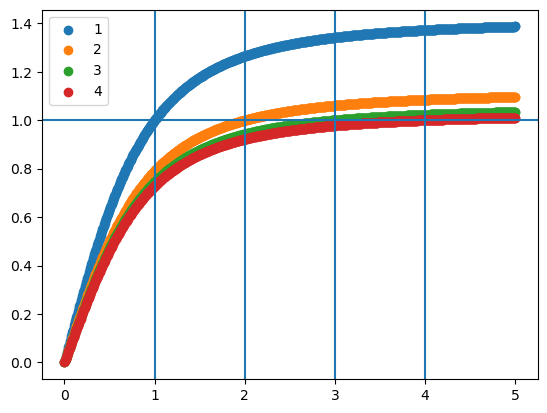

In [ ]:
for inputs_star in [1, 2, 3, 4]:
    model.inputs_star = inputs_star
    pred = model.apply({"params": params}, inputs)
    plt.scatter(inputs.ravel(), pred.ravel(), label=inputs_star)
    plt.axvline(inputs_star)

plt.axhline(1)
plt.legend()
plt.show()

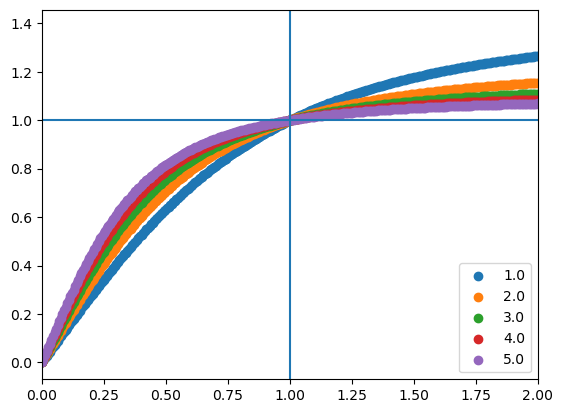

In [ ]:
model.inputs_star = 1
for H in [1., 2., 3., 4., 5.]:
    params = unfreeze(params)
    params["Conv_0"]["kernel"] *= 0.
    params["Conv_0"]["kernel"] += H
    params = freeze(params)
    pred = model.apply({"params": params}, inputs)
    plt.scatter(inputs.ravel(), pred.ravel(), label=H)
plt.axhline(1)
plt.axvline(1)
plt.legend()
plt.xlim([0,2])
plt.show()

We can even specify a different value of $x^*$ for each input channel:

In [ ]:
model = GDNStar(kernel_size=(1,1), inputs_star=jnp.array([1.,2.,3.,4.]))
key1, key2 = random.split(random.PRNGKey(0), 2)
inputs = jnp.ones(shape=(1,28,28,4))
variables = model.init(key2, inputs)
state, params = variables.pop("params")
pred = model.apply({"params": params}, inputs)
assert len(jnp.unique(jnp.unique(jnp.unique(pred, 0), 0), 0)) == 4

## GDN star (positives and negatives)

In [ ]:
#| export
class GDNStarSign(nn.Module):
    """GDN variation that forces the output to be 1 when the input is x^*"""

    kernel_size: Sequence[int]
    apply_independently: bool = False
    inputs_star: Union[float, Sequence[float]] = 1.
    alpha: float = 2.
    epsilon: float = 1/2
    # kernel_init = nn.initializers.ones_init()
    # bias_init = nn.initializers.ones_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        inputs_sign = jnp.sign(inputs)
        inputs = jnp.abs(inputs)
        H = nn.Conv(features=inputs.shape[-1], kernel_size=self.kernel_size, use_bias=True, feature_group_count=inputs.shape[-1] if self.apply_independently else 1)#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        inputs_star = jnp.ones_like(inputs)*self.inputs_star
        denom = jnp.clip(H(inputs**self.alpha), a_min=1e-5)**self.epsilon
        coef = (jnp.clip(H(inputs_star**self.alpha), a_min=1e-5)**self.epsilon)/inputs_star
        return coef*inputs*inputs_sign/denom

In [ ]:
model = GDNStarSign(kernel_size=(1,1))
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(1,28,28,1))
variables = model.init(key2, x)
state, params = variables.pop("params")

In [ ]:
params = unfreeze(params)
params["Conv_0"]["kernel"] *= 0.
params["Conv_0"]["kernel"] += 1.
params["Conv_0"]["bias"] += 1.
params = freeze(params)
params

FrozenDict({
    Conv_0: {
        bias: Array([1.], dtype=float32),
        kernel: Array([[[[1.]]]], dtype=float32),
    },
})

In [ ]:
inputs = jnp.linspace(-5, 5, num=28*28).reshape((1,28,28,1))

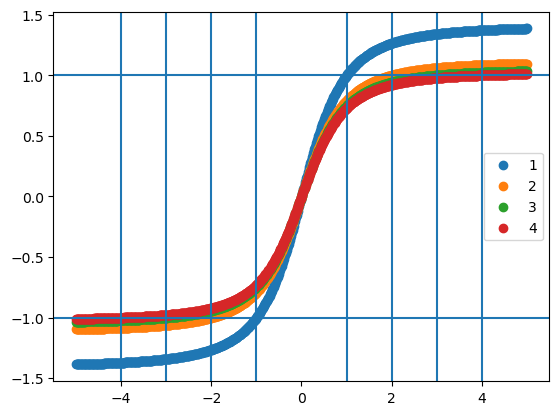

In [ ]:
for inputs_star in [1, 2, 3, 4]:
    model.inputs_star = inputs_star
    pred = model.apply({"params": params}, inputs)
    plt.scatter(inputs.ravel(), pred.ravel(), label=inputs_star)
    plt.axvline(inputs_star)
    plt.axvline(-inputs_star)

plt.axhline(1)
plt.axhline(-1)
plt.legend()
plt.show()

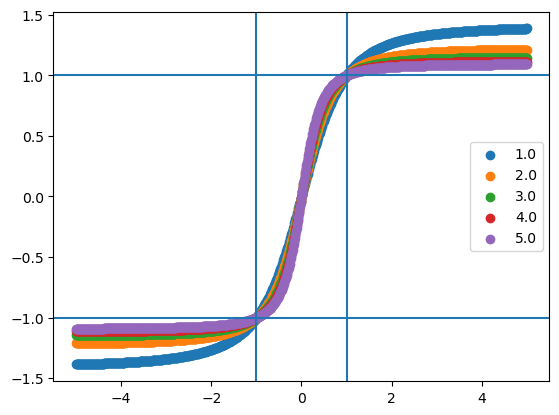

In [ ]:
model.inputs_star = 1
for H in [1., 2., 3., 4., 5.]:
    params = unfreeze(params)
    params["Conv_0"]["kernel"] *= 0.
    params["Conv_0"]["kernel"] += H
    params = freeze(params)
    pred = model.apply({"params": params}, inputs)
    plt.scatter(inputs.ravel(), pred.ravel(), label=H)
plt.axhline(1)
plt.axvline(1)
plt.axhline(-1)
plt.axvline(-1)
plt.legend()
# plt.xlim([0,2])
plt.show()

## GDN (Displacement)

In [ ]:
inputs = jnp.linspace(-10, 10, num=28*28).reshape((1,28,28,1))

In [ ]:
#| export
class GDNDisplacement(nn.Module):
    """GDN variation that forces the output to be 1 when the input is x^*"""

    kernel_size: Sequence[int]
    apply_independently: bool = False
    inputs_star: Union[float, Sequence[float]] = 1.
    alpha: float = 2.
    epsilon: float = 1/2
    # kernel_init = nn.initializers.ones_init()
    # bias_init = nn.initializers.ones_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        # inputs_sign = jnp.sign(inputs)
        # inputs = jnp.abs(inputs)
        inputs_mean = inputs.mean(axis=(1,2), keepdims=True)
        inputs_mean = jnp.ones_like(inputs)*inputs_mean
        H = nn.Conv(features=inputs.shape[-1], kernel_size=self.kernel_size, use_bias=True, feature_group_count=inputs.shape[-1] if self.apply_independently else 1)#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        # inputs_star = jnp.ones_like(inputs)*self.inputs_star
        denom = jnp.clip(H((inputs-inputs_mean)**self.alpha), a_min=1e-5)**self.epsilon
        # coef = (jnp.clip(H(inputs_star**self.alpha), a_min=1e-5)**self.epsilon)/inputs_star
        coef = 1.
        return coef*(inputs-inputs_mean)/denom

In [ ]:
model = GDNDisplacement(kernel_size=(1,1))
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(1,28,28,1))
variables = model.init(key2, x)
state, params = variables.pop("params")

In [ ]:
params = unfreeze(params)
params["Conv_0"]["kernel"] *= 0.
params["Conv_0"]["kernel"] += 1.
params["Conv_0"]["bias"] += 1.
params = freeze(params)
params

FrozenDict({
    Conv_0: {
        bias: Array([1.], dtype=float32),
        kernel: Array([[[[1.]]]], dtype=float32),
    },
})

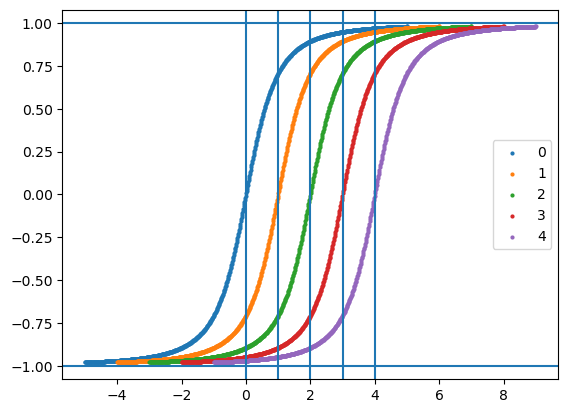

In [ ]:
for inputs_mean in [0, 1, 2, 3, 4]:
    inputs_ = jnp.linspace(-5, 5, num=28*28).reshape((1,28,28,1)) + inputs_mean
    pred = model.apply({"params": params}, inputs_)
    plt.scatter(inputs_.ravel(), pred.ravel(), label=inputs_mean, s=4)
    plt.axvline(inputs_mean)

plt.axhline(1)
plt.axhline(-1)
plt.legend()
plt.show()

In [ ]:
#| export
class GDNStarDisplacement(nn.Module):
    """GDN variation that forces the output to be 1 when the input is x^*"""

    kernel_size: Sequence[int]
    apply_independently: bool = False
    inputs_star: Union[float, Sequence[float]] = 1.
    alpha: float = 2.
    epsilon: float = 1/2
    # kernel_init = nn.initializers.ones_init()
    # bias_init = nn.initializers.ones_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        # inputs_sign = jnp.sign(inputs)
        # inputs = jnp.abs(inputs)
        inputs_mean = inputs.mean(axis=(1,2), keepdims=True)
        inputs_mean = jnp.ones_like(inputs)*inputs_mean
        H = nn.Conv(features=inputs.shape[-1], kernel_size=self.kernel_size, use_bias=True, feature_group_count=inputs.shape[-1] if self.apply_independently else 1)#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        inputs_star = jnp.ones_like(inputs)*self.inputs_star
        denom = jnp.clip(H((inputs-inputs_mean)**self.alpha), a_min=1e-5)**self.epsilon
        coef = (jnp.clip(H(inputs_star**self.alpha), a_min=1e-5)**self.epsilon)/inputs_star
        # coef = 1.
        return coef*(inputs-inputs_mean)/denom

In [ ]:
model = GDNStarDisplacement(kernel_size=(1,1))
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(1,28,28,1))
variables = model.init(key2, x)
state, params = variables.pop("params")

In [ ]:
params = unfreeze(params)
params["Conv_0"]["kernel"] *= 0.
params["Conv_0"]["kernel"] += 1.
params["Conv_0"]["bias"] += 1.
params = freeze(params)
params

FrozenDict({
    Conv_0: {
        bias: Array([1.], dtype=float32),
        kernel: Array([[[[1.]]]], dtype=float32),
    },
})

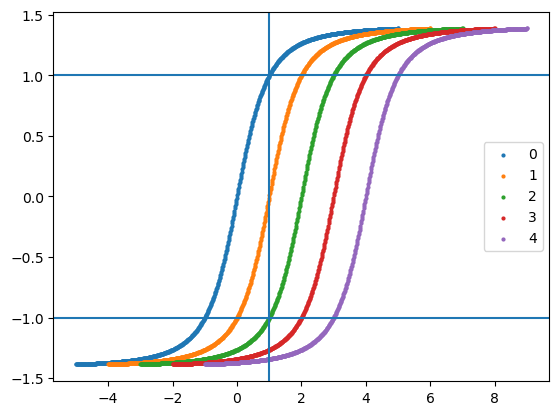

In [ ]:
for inputs_mean in [0, 1, 2, 3, 4]:
    inputs_ = jnp.linspace(-5, 5, num=28*28).reshape((1,28,28,1)) + inputs_mean
    pred = model.apply({"params": params}, inputs_)
    plt.scatter(inputs_.ravel(), pred.ravel(), label=inputs_mean, s=4)
plt.axvline(1)

plt.axhline(1)
plt.axhline(-1)
plt.legend()
# plt.ylim([-1,1])
plt.show()

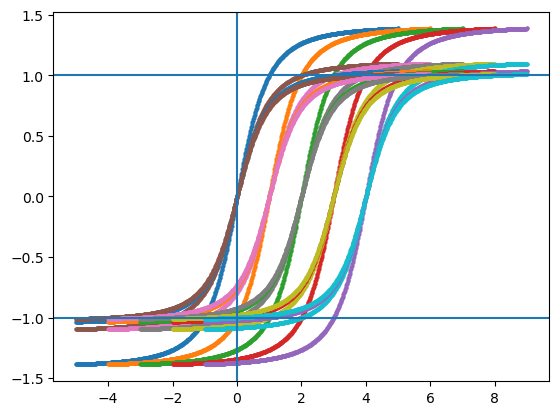

In [ ]:
inputs_mean = 0.
for inputs_star in [1, 2, 3, 4]:
    for inputs_mean in [0, 1, 2, 3, 4]:
        model.inputs_star = inputs_star
        inputs_ = jnp.linspace(-5, 5, num=28*28).reshape((1,28,28,1)) + inputs_mean
        pred = model.apply({"params": params}, inputs_)
        plt.scatter(inputs_.ravel(), pred.ravel(), label=f"x*={inputs_star} / x_mean={inputs_mean}", s=4)
plt.axvline(0)

plt.axhline(1)
plt.axhline(-1)
# plt.legend()
# plt.ylim([-1,1])
plt.show()

## GDN Batch-Norm-Like

In [ ]:
#| export
class GDNStarRunning(nn.Module):
    """GDN variation where x^* is obtained as a running mean of the previously obtained values."""

    kernel_size: Sequence[int]
    apply_independently: bool = False
    # inputs_star: float = 1.
    alpha: float = 2.
    epsilon: float = 1/2
    # kernel_init = nn.initializers.ones_init()
    bias_init: Callable = nn.initializers.ones_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 **kwargs,
                 ):
        # inputs_sign = jnp.sign(inputs)
        # inputs = jnp.abs(inputs)
        is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: x, jnp.quantile(inputs, q=0.95))
        inputs_star = self.variable("batch_stats", "inputs_star", jnp.ones, (1,))
        H = nn.Conv(features=inputs.shape[-1], kernel_size=self.kernel_size, use_bias=True, feature_group_count=inputs.shape[-1] if self.apply_independently else 1, bias_init=self.bias_init)
        inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        denom = jnp.clip(H((inputs)**self.alpha), a_min=1e-5)**self.epsilon
        coef = (jnp.clip(H(inputs_star_**self.alpha), a_min=1e-5)**self.epsilon)#/inputs_star_
        if is_initialized and train:
            inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95))/2
        return coef*inputs/denom

In [ ]:
model = GDNStarRunning(kernel_size=(1,1))
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(1,28,28,1))
variables = model.init(key2, x)
state, params = variables.pop("params")

In [ ]:
params = unfreeze(params)
params["Conv_0"]["kernel"] *= 0.
params["Conv_0"]["kernel"] += 1.
params["Conv_0"]["bias"] += 1.
params = freeze(params)

In [ ]:
outputs, updated_state = model.apply({"params": params, **state}, x, train=False, mutable=list(state.keys()))
assert updated_state == state

In [ ]:
outputs, updated_state = model.apply({"params": params, **state}, x, train=True, mutable=list(state.keys()))
assert updated_state != state

[2.875]
[3.8125]
[4.28125]
[4.515625]
[4.6328125]
[4.6914062]
[4.720703]


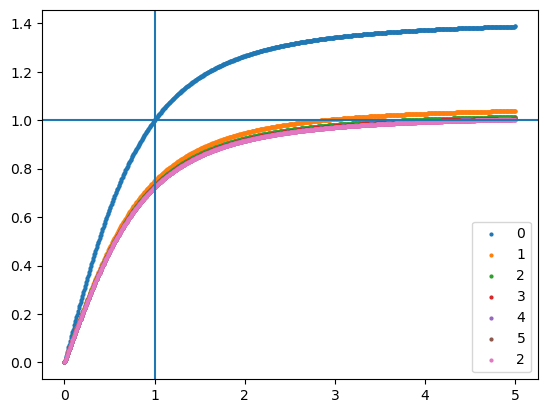

In [ ]:
updated_state = state
for inputs_mean in [0, 1, 2, 3, 4, 5, 2]:
    inputs_ = jnp.linspace(0, 5, num=28*28).reshape((1,28,28,1))# + inputs_mean
    pred, updated_state = model.apply({"params": params, **updated_state}, inputs_, train=True, mutable=list(state.keys()))
    print(updated_state["batch_stats"]["inputs_star"])
    plt.scatter(inputs_.ravel(), pred.ravel(), label=inputs_mean, s=4)
plt.axvline(1)

plt.axhline(1)
plt.legend()
# plt.ylim([-1,1])
plt.show()

## GDN Batch-Norm-Like (Displacement)

In [ ]:
#| export
class GDNStarDisplacementRunning(nn.Module):
    """GDN variation where x^* is obtained as a running mean of the previously obtained values."""

    kernel_size: Sequence[int]
    apply_independently: bool = False
    # inputs_star: float = 1.
    alpha: float = 2.
    epsilon: float = 1/2
    # kernel_init = nn.initializers.ones_init()
    # bias_init = nn.initializers.ones_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 **kwargs,
                 ):
        # inputs_sign = jnp.sign(inputs)
        # inputs = jnp.abs(inputs)
        is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: x, jnp.quantile(inputs, q=0.95))
        inputs_star = self.variable("batch_stats", "inputs_star", jnp.ones, (1,))
        inputs_mean = inputs.mean(axis=(1,2), keepdims=True)
        inputs_mean = jnp.ones_like(inputs)*inputs_mean
        H = nn.Conv(features=inputs.shape[-1], kernel_size=self.kernel_size, use_bias=True, feature_group_count=inputs.shape[-1] if self.apply_independently else 1)#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        denom = jnp.clip(H((inputs-inputs_mean)**self.alpha), a_min=1e-5)**self.epsilon
        coef = (jnp.clip(H(inputs_star_**self.alpha), a_min=1e-5)**self.epsilon)/inputs_star_
        if is_initialized and train:
            inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95))/2
        return coef*(inputs-inputs_mean)/denom

In [ ]:
model = GDNStarDisplacementRunning(kernel_size=(1,1))
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(1,28,28,1))
variables = model.init(key2, x)
state, params = variables.pop("params")

In [ ]:
params = unfreeze(params)
params["Conv_0"]["kernel"] *= 0.
params["Conv_0"]["kernel"] += 1.
params["Conv_0"]["bias"] += 1.
params = freeze(params)

In [ ]:
outputs, updated_state = model.apply({"params": params, **state}, x, train=False, mutable=list(state.keys()))
assert updated_state == state

In [ ]:
outputs, updated_state = model.apply({"params": params, **state}, x, train=True, mutable=list(state.keys()))
assert updated_state != state

[2.8777137]
[4.188857]
[5.3444285]
[6.4222145]
[7.4611073]
[8.480554]
[7.490277]


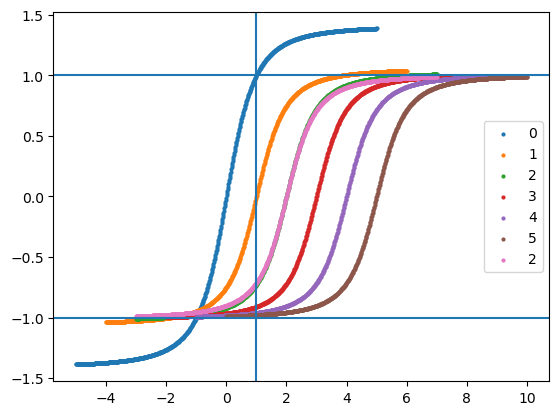

In [ ]:
updated_state = state
for inputs_mean in [0, 1, 2, 3, 4, 5, 2]:
    inputs_ = jnp.linspace(-5, 5, num=28*28).reshape((1,28,28,1)) + inputs_mean
    pred, updated_state = model.apply({"params": params, **updated_state}, inputs_, train=True, mutable=list(state.keys()))
    print(updated_state["batch_stats"]["inputs_star"])
    plt.scatter(inputs_.ravel(), pred.ravel(), label=inputs_mean, s=4)
plt.axvline(1)

plt.axhline(1)
plt.axhline(-1)
plt.legend()
# plt.ylim([-1,1])
plt.show()

<!-- ## GDN (Gaussian Channel Interaction) -->
## Gaussian Frequency Interaction

In some cases it may make sense to model specifically the interaction between frequencies so that closer frequencies interact more than further away frequencies, so we can design a GDN that takes this into account by introducing a Gaussian into it.

May be necessary to combine the interaction and the Gabor in the same layer so that the Gaussian can receive the Gabor frequencies.

In [ ]:
#| export
class FreqGaussian(nn.Module):
    """(1D) Gaussian interaction between frequencies."""
    use_bias: bool = False
    strides: int = 1
    padding: str = "SAME"
    bias_init: Callable = nn.initializers.zeros_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 **kwargs,
                 ):
        sigma = self.param("sigma",
                           k_array(0.4, arr=1/fmean),
                           (inputs.shape[-1],))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (len(fmean),))
        else: bias = 0.
        n_groups = inputs.shape[-1] // len(fmean)
        kernel = jax.vmap(self.gaussian, in_axes=(None,0,0,None), out_axes=0)(fmean, fmean, sigma, 1)
        kernel = kernel[None,None,:,:]
        kernel = jnp.repeat(kernel, repeats=n_groups, axis=-1)

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv_general_dilated(
                jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
                jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
                (self.strides, self.strides),
                self.padding,
                feature_group_count=n_groups)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(f, fmean, sigma, A=1):
        return A*jnp.exp(-((f-fmean)**2)/(2*sigma**2))

In [ ]:
fmean = jnp.array([2., 8., 4.])
model = FreqGaussian()
variables = model.init(random.PRNGKey(42), jnp.ones(shape=(1,28,28,3)), fmean=fmean)
state, params = variables.pop("params")

In [ ]:
params

FrozenDict({
    sigma: Array([0.8, 3.2, 1.6], dtype=float32),
})

(3, 3)


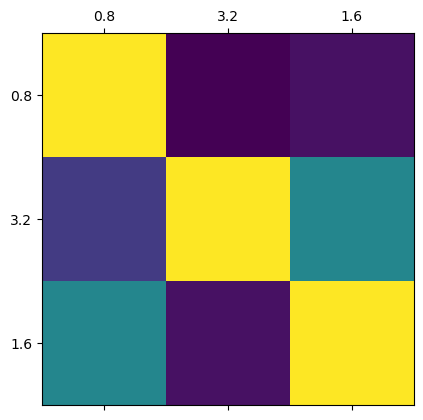

In [ ]:
sigma = jnp.array([5, 0.8, 1.2])
kernel = jax.vmap(model.gaussian, in_axes=(None,0,0,None))(fmean, fmean, params["sigma"], 1)
print(kernel.shape)
plt.matshow(kernel)
plt.xticks(ticks=range(len(params["sigma"])), labels=params["sigma"])
plt.yticks(ticks=range(len(params["sigma"])), labels=params["sigma"])
plt.show()

To test it in combination with the `GaborLayer_` we can define a simple module combining them both. This is needed because we need to be able to get the `freq` from the Gabors and then pass it to the `FreqGaussian` layer.

In [ ]:
class Model(nn.Module):
    """Dummy model to test the combination of the `GaborLayer_` and the `FreqGaussian` layer."""
    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        outputs, fmean = GaborLayer_(n_scales=4, n_orientations=10, kernel_size=64, fs=64, normalize_prob=True, normalize_energy=False)(inputs, **kwargs, return_freq=True)
        outputs = FreqGaussian()(outputs, fmean=fmean)
        return outputs

In [ ]:
model = Model()
variables = model.init(random.PRNGKey(42), jnp.ones(shape=(1,28,28,1)))
state, params = variables.pop("params")

## Orient Gaussian

Almost like the `FreqGaussian` but taking into account that degrees are in a circular domain.

In [ ]:
#| exporti
def wrapTo180(angle, # Deg
              ):
    """Wraps an angle to the range [-180, 180]."""
    angle =  angle % 360
    angle = (angle + 360) % 360        
    return jnp.where(angle>180, angle-360, angle)

In [ ]:
assert wrapTo180(0) == 0
assert wrapTo180(181) == -179
assert wrapTo180(-190) == 170

In [ ]:
#| exporti
def process_angles(angle1, # Deg.
                   angle2, # Deg
                   ):
    """Takes two angles as input and outputs their difference making all necessary assumptions."""
    dif = angle1 - angle2
    dif2 = dif + 180
    return jnp.min(jnp.stack([jnp.abs(wrapTo180(dif)), jnp.abs(wrapTo180(dif2))]), axis=0)

In [ ]:
theta = 380
angle = process_angles(jnp.array([0., 45.]), jnp.array([362., -45.]))#*jnp.pi/180.
angle

Array([ 2., 90.], dtype=float32)

In [ ]:
#| export
class OrientGaussian(nn.Module):
    """(1D) Gaussian interaction between orientations."""
    use_bias: bool = False
    strides: int = 1
    padding: str = "SAME"
    bias_init: Callable = nn.initializers.zeros_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 theta_mean,
                 **kwargs,
                 ):
        sigma = self.param("sigma",
                        #    equal_to([jnp.pi/4]*len(theta_mean)),
                           equal_to([30]*len(theta_mean)),
                           (inputs.shape[-1],))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (len(fmean),))
        else: bias = 0.
        n_groups = inputs.shape[-1] // len(theta_mean)
        kernel = jax.vmap(self.gaussian, in_axes=(None,0,0,None), out_axes=0)(theta_mean, theta_mean, sigma, 1)
        kernel = kernel[None,None,:,:]
        kernel = jnp.repeat(kernel, repeats=n_groups, axis=-1)

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv_general_dilated(
                jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
                jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
                (self.strides, self.strides),
                self.padding,
                feature_group_count=n_groups)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(theta, theta_mean, sigma, A=1):
        return A*jnp.exp(-(process_angles(theta, theta_mean)**2)/(2*sigma**2))

In [ ]:
theta_mean = jnp.array([45, 90, 359])
model = OrientGaussian()
variables = model.init(random.PRNGKey(42), jnp.ones(shape=(1,28,28,3)), theta_mean=theta_mean)
state, params = variables.pop("params")

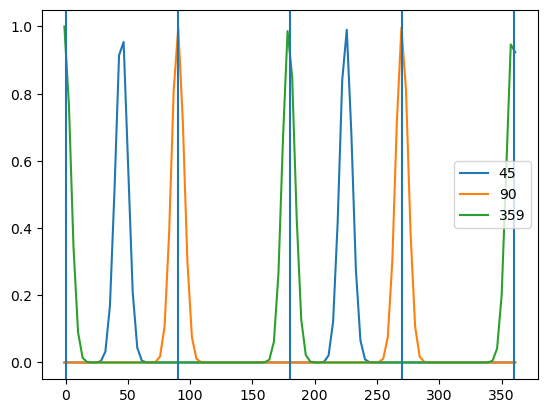

In [ ]:
t = jnp.linspace(-1., 361., num=100)
k = jax.vmap(model.gaussian, in_axes=(None,0,None,None))(t, theta_mean, 5., 1)
for kk, tm in zip(k, theta_mean): plt.plot(t, kk, label=tm)
for tm in [0., 90., 180., 270., 360.]: plt.axvline(tm)
plt.legend()
plt.show()

When we are considering a 0 deg filter, we want it to have the maximum relation with both 0 deg and 180 deg. By visualizing the previous graph, we see that we are obtaining what we wanted.

In [ ]:
params

FrozenDict({
    sigma: Array([30., 30., 30.], dtype=float32),
})

(3, 3)


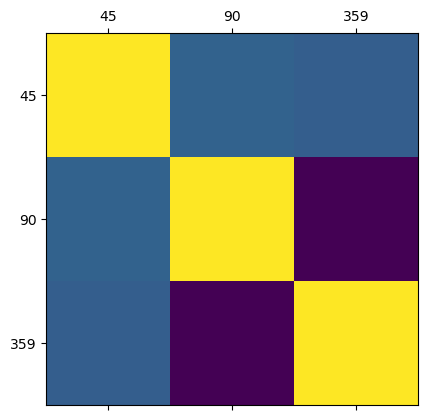

In [ ]:
kernel = jax.vmap(model.gaussian, in_axes=(None,0,0,None))(theta_mean, theta_mean, params["sigma"], 1)
print(kernel.shape)
plt.matshow(kernel)
plt.xticks(ticks=range(len(params["sigma"])), labels=theta_mean)
plt.yticks(ticks=range(len(params["sigma"])), labels=theta_mean)
plt.show()

To test it in combination with the `GaborLayer_` we can define a simple module combining them both. This is needed because we need to be able to get the `theta` from the Gabors and then pass it to the `OrientGaussian` layer.

> A very important difference with respect to the `FreqGaussian` case is that the Gabor filters in `GaborLayer_` need to be reordered so that we can apply them in the same way.

In [ ]:
class Model(nn.Module):
    """Dummy model to test the combination of the `GaborLayer_` and the `OrientGaussian` layer."""
    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        b, h, w, c = inputs.shape
        outputs, theta_mean = GaborLayer_(n_scales=4, n_orientations=10, kernel_size=64, fs=64, normalize_prob=True, normalize_energy=False)(inputs, **kwargs, return_theta=True)
        ## Reshape so that the orientations are the innermost dimmension
        outputs = rearrange(outputs, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=4, theta=10)
        outputs = OrientGaussian()(outputs, theta_mean=theta_mean)
        ## Recover original disposition
        outputs = rearrange(outputs, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=4, theta=10)
        return outputs

In [ ]:
model = Model()
variables = model.init(random.PRNGKey(42), jnp.ones(shape=(1,28,28,1)))
state, params = variables.pop("params")

### Putting it all together

We can even combine both layers in a separable-interaction-way.

In [ ]:
class Model(nn.Module):
    """Dummy model to test the combination of the `GaborLayer_` and the `OrientGaussian` layer."""
    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        b, h, w, c = inputs.shape
        outputs, fmean, theta_mean = GaborLayer_(n_scales=4, n_orientations=10, kernel_size=64, fs=64, normalize_prob=True, normalize_energy=False)(inputs, return_freq=True, return_theta=True, **kwargs)
        outputs = FreqGaussian()(outputs, fmean=fmean)
        ## Reshape so that the orientations are the innermost dimmension
        outputs = rearrange(outputs, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=4, theta=10)
        outputs = OrientGaussian()(outputs, theta_mean=theta_mean)
        ## Recover original disposition
        outputs = rearrange(outputs, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=4, theta=10)
        return outputs

In [ ]:
model = Model()
variables = model.init(random.PRNGKey(42), jnp.ones(shape=(1,28,28,1)))
state, params = variables.pop("params")